# Semi-microscopic constraints of nuclear symmetry energy parameters

This notebook derives constraints on the nuclear symmetry energy parameters $(S_v,L)$ from chiral EFT calculations in pure neutron matter combined with empirical constraints on the nuclear saturation point.

The notebook is a minimalistic version of BUQEYE's [`derivatives-bands.ipynb`](https://github.com/buqeye/nuclear-matter-convergence/blob/master/analysis/derivatives-bands.ipynb) for this specific purpose.

## Installation

Navigate to the root directory of the `nuclear_saturation` repository and follow these instructions to install the code:

```shell
python3 -m venv env_esym  # in the root dir of this repository
source env_esym/bin/activate
python3 -m pip install -r requirements_esym.txt
python3 -m ipykernel install --name "nuclear-esym"
```

For completeness, we state the packages would need to be installed manually:
```shell
python3 -m pip install numpy
python3 -m pip install sympy
python3 -m pip install jupyter
python3 -m pip install corner
python3 -m pip install arviz
python3 -m pip install gsum
python3 -m pip install pymc3
python3 -m pip install statsmodels
python3 -m pip install docrep
python3 -m pip install findiff
python3 -m pip install seaborn
python3 -m pip uninstall gsum
python3 -m pip uninstall gptools
python3 -m pip install git+https://github.com/buqeye/gsum
python3 -m pip install Cython
python3 -m pip install git+https://github.com/markchil/gptools
python3 -m pip install tqdm
```

Clone BUQEYE's GitHub repository [nuclear-matter-convergence](https://github.com/buqeye/nuclear-matter-convergence) to your computer [e.g., in `~/GitHub/nuclear-matter-convergence`] and tell your Python interpreter where to find it:

In [11]:
import sys
PATH_BUQEYE_NUCLMATT = '~/GitHub/nuclear-matter-convergence' # this might be different
sys.path.append(PATH_BUQEYE_NUCLMATT)

Now, you should be able to import the BUQEYE packages for EOS truncation error analysis and sampling:

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from scipy import stats
import pandas as pd
from nuclear_matter import fermi_momentum, nuclear_density, kf_derivative_wrt_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation
from nuclear_matter.derivatives import ObservableContainer

Deprecation Warning: 'triangle' has been renamed to 'corner'. This shim should continue to work but you should use 'import corner' in new code. https://github.com/dfm/corner.py


## Sampling strategy

As discussed in the manuscript, we use the standard quadratic approximation of the EOS's isospin dependence to constraint $(S_v,L)$:

\begin{align} 
    S_v = \frac{E}{N}(n_0) - E_0 \quad \text{and} \quad 
%   L &= 3n_0 \dv{n}\frac{E}{N}(n)\bigg|_{n=n_0} \,.
    L = \frac{3}{n_0} p(n_0) =  3 n_0  \frac{d}{dn} \frac{E}{N}(n) \big|_{n=n_0}\,.
% P(n_0) &= n^2 \dv{n} \frac{E}{N}(n)\bigg|_{n=n_0} \, ,
\end{align}

The microscopic input of our calculations are the neutron matter results for $(E(n_0)/N, p(n_0))$ obtained by the BUQEYE collaboration (see their [GitHub repository](https://github.com/buqeye/nuclear-matter-convergence)) with correlated to-all-orders EFT truncation errors fully quantified.

The empirical input of our calculations are our inferred empirical saturation points. 

Specifically, we marginalize as follows:
$$
P(S_v,L) = \int dn_0 \int dE_0 \, P(S_v,L \mid n_0, E_0) \, P(n_0, E_0)\,,
$$
where $P(n_0, E_0)$ is the posterior predictive obtained in our manuscript.

In [20]:
def sample_sv_l(posterior_predict_params, num_sats=101, num_GP_samples=50, Lambda=500, high_density=True):
    """
    samples (S_v,L) as described above.

    Parameters:
    -----------
    posterior_predict_params: dict() specifiying the mean vector, scale matrix, and dof 
    of the (empirical) saturation point
    num_sats: number of samples from the empirical saturation point
    num_GP_samples: number of samples from the PNM GP-B EOS (at N3LO) per empirical saturation point sample
    Lambda: either 450 or 500 (in MeV): momentum cutoff of the interactions
    high_density: (boolean) whether the results up to 2nsat or just 1.2nsat should be used 
    (shouldn't make a difference for this application)

    [This function could be written more efficiently.]
    """

    # initializing of the GPs for the PNM EOS following the
    # BUQEYE Jupyter notebooks for the nuclear matter convergence
    if Lambda not in (500, 450):
        raise ValueError(f"Requested Lambda {Lambda} not supported.")

    if high_density:
        filename = f'{PATH_BUQEYE_NUCLMATT}/data/all_matter_data_high_density.csv'
    else:
        filename = '{PATH_BUQEYE_NUCLMATT}/data/all_matter_data.csv'
        
    data = InputData(filename, Lambda)
    density = data.density
    kf_n = data.kf_n
    density_all = np.arange(density[0], density[-1], 0.005)
    kf_n_all = fermi_momentum(density_all, degeneracy=2)
    y_n_2_plus_3bf = data.y_n_2_plus_3bf
    orders = np.array([0, 2, 3, 4])
    breakdown = 600 # MeV
    verbose = True
    kf0_n = fermi_momentum(0.16, 2)  # constant value, consistent with BUQEYE paper(s)

    ref_neutron = 16 / kf0_n**2

    if Lambda == 500:
        std_neutron = 1.00
        ls_neutron = 0.973
    elif Lambda == 450:
        std_neutron = 0.8684060649936118
        ls_neutron = 0.7631421388401067
    min_uncertainty = 0.02  # Twenty keV
    uncertainty_factor = 0.001  # 0.1%
    err_y_n = np.abs(y_n_2_plus_3bf[:, -1]) * uncertainty_factor
    err_y_n[np.abs(err_y_n) < min_uncertainty] = min_uncertainty
    obs_neutron = ObservableContainer(
        density=density,
        kf=kf_n,
        y=y_n_2_plus_3bf,
        orders=orders,
        density_interp=density_all,
        kf_interp=kf_n_all,
        std=std_neutron,
        ls=ls_neutron,
        ref=ref_neutron,
        breakdown=breakdown,
        err_y=err_y_n,
        include_3bf=False,
        derivs=[0, 1, 2],
        verbose=verbose,
    )
    # emp_sat_point_dist = stats.multivariate_normal(
    #     mean=[0.17, -16.], 
    #     cov=np.diag([0.01**2, 0.1**2])
    # )

    # use a default PPD for the empirical saturation point,
    # if none is provided
    if posterior_predict_params is None:
        dist_kwargs = dict(
            loc=[  0.16083667, -15.9292    ], 
            shape=np.array([[1.07708821e-05, 1.65382275e-04],
            [1.65382275e-04, 2.74842604e-02]]),
            df=17
        )
    else:
        dist_kwargs = dict(
            loc=posterior_predict_params["mu"], 
            shape=posterior_predict_params["Psi"],
            df=posterior_predict_params["nu"]
        )    

    # the posterior predictive is a bivariate t-distribution;
    # sample PNM E/N and pressure from GP-B
    emp_sat_point_dist = stats.multivariate_t(**dist_kwargs)
    np.random.seed(512)
    de_sats = np.atleast_2d(emp_sat_point_dist.rvs(num_sats))
    d_sats = de_sats[:, 0]
    e_sats = de_sats[:, 1]
    kf_n_sats = fermi_momentum(d_sats, 2)
    Kf_n_sats = kf_n_sats[:, None]

    def compute_Esym_L(kf, n, e, E_dE, E_dE_cov):
        """
        computes (S_v=Esym,L) for a given Fermi momentum `kf`, corresponding density `n` and SNM energy `e`;
        `S2_dS2` and `S2_dS2_cov` are the (value, derivative) and joint covariance matrix of the
        energy per neturon (E/N) and it's density derivative (E'/N) at that density `n`. 
        """
        to_Esym_L_mat = np.array([
            [1, 0],
            [0, 3*n*kf_derivative_wrt_density(kf, n)]  # the derivative is w.r.t. to kf, not the density
        ])
        S2_L = to_Esym_L_mat @ E_dE - np.array([e, 0])
        S2_L_cov = to_Esym_L_mat @ E_dE_cov @ to_Esym_L_mat.T
        return S2_L, S2_L_cov

    from tqdm import tqdm
    np.random.seed(1024)
    df = []
    for index in tqdm(range(num_sats), desc="Sampling emp. sat. point"):  # could be easily parallelized
        E_dE, E_dE_cov = obs_neutron.predict(np.atleast_2d(Kf_n_sats[index]), order=4, derivs=[0, 1])   # order is 4 (N3LO)
        E_L_mean, E_L_cov = compute_Esym_L(kf=kf_n_sats[index], n=d_sats[index], e=e_sats[index],
                                           E_dE=E_dE, E_dE_cov=E_dE_cov)
        # note that the derivative is w.r.t. kf, not the density
        sample = stats.multivariate_normal.rvs(mean=E_L_mean, cov=E_L_cov, size=num_GP_samples)
        df.append(pd.DataFrame(np.atleast_2d(sample), columns=("Sv", "L")))
    return pd.concat(df)

Let's run a simple sanity test, assuming the saturation point is given by exactly the canonical value of (0.16 $\mathrm{fm}^{-3}$, -16 MeV). In that case, we ought to reproduce BUQEYE's published results for the marginal distributions:

In [35]:
nsat, esat = 0.16, -16.  # fm**-3 / MeV
dist_kwargs = dict(
            mu=[  nsat, esat    ], 
            Psi=np.eye(2)*1e-9,
            nu=160000  # normal
        )

dat = sample_sv_l(posterior_predict_params=dist_kwargs, num_sats=1, num_GP_samples = 50000000, Lambda=500)
dat_mean = dat.mean()
dat_std = np.sqrt(np.diag(dat.cov()))
print(f'Sv (sampled): {dat_mean["Sv"]:.3f} +/- {dat_std[0]:.3f} MeV')
print("expected Sv [MeV]", np.array([16.362972180704700 - esat, 0.9868380045082120]))  # Sv (data from BUQEYE)  # for 500 MeV interaction
print(f'L (sampled): {dat_mean["L"]:.3f} +/- {dat_std[1]:.3f} MeV')
print("expected L [MeV]", np.array([2.8978682916931900, 0.4041150279261480]) * 3. / nsat)  # Slope parameter (mean, std; data from BUQEYE)  # for 500 MeV interaction

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


Sv (sampled): 32.362 +/- 0.987 MeV
expected Sv [32.36297218  0.986838  ]
L (sampled): 54.331 +/- 7.577 MeV
expect L [54.33503047  7.57715677]


The sample estimates and expected values match well. Note that since the empirical saturation point is given by a point estimate, we only need to sample it only once. We can perform another check by plotting the samples with more samples, including more samples from the distribution describing the empirical saturation point:

For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10100/10100 [03:37<00:00, 46.47it/s]


Pandas support in corner is deprecated; use ArviZ directly


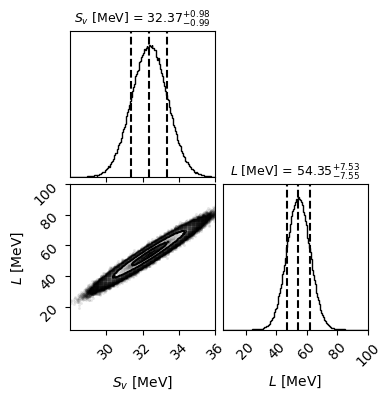

In [38]:
import matplotlib.pyplot as plt
import arviz as az
import corner
df = sample_sv_l(posterior_predict_params=dist_kwargs, num_sats=10100, num_GP_samples=50, Lambda=500)
fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
fig = corner.corner(
    data=df,
    range=[(28, 36), (5, 100)],
    labels=[r'$S_v$ [MeV]', r'$L$ [MeV]'], 
    fig=fig,
    bins=180,
    quantiles=(0.16, 0.5, 0.84),  # note that the median (=0.5) and mean may be (slightly different)
    levels=(1-np.exp(-0.5), 1-np.exp(-0.5*2**2)),
    show_titles=True, 
    title_kwargs={"fontsize": 9}
)

## Sampling nuclear symmetry parameters

First, we need to import the inferred (empirical) saturation points. They are located in the folder `samples`:

In [44]:
import pickle
filename = "./samples/results_posteriors.pkl"
with open(filename, 'rb') as fp:
    res_postpred = pickle.load(fp)

Next, we can use the empirical saturation points (together with the microscopic PNM calculations) to constraint $(S_v,L)$ for all prior sets, scenarios, and momentum cutoffs:

In [45]:
from modules.plot_helpers import confidence_ellipse, fit_bivariate_t
for Lambda in (500, 450):  # MeV
    ret = {}
    for prior_set_lbl, results in res_postpred.items():
        print(f"Working on prior '{prior_set_lbl}' ({Lambda} Mev interaction)")
        print("-"*50)
        ret_data = {}
        for res_lbl, post_pred in results.items():
            print("\twith data config:", res_lbl)
            samples = sample_sv_l(num_sats=10000, num_GP_samples=800, Lambda=Lambda, posterior_predict_params=post_pred)  # 101000
            fit = fit_bivariate_t(samples.to_numpy(), alpha_fit=0.68, nu_limits=None, tol=1e-2, print_status=False)
            ret_data[res_lbl] = {"satpoint_dist": results, "cov": samples.cov().to_numpy(), **fit}
            # fit2 = fit_bivariate_t(samples.to_numpy(), alpha_fit=0.68, nu_limits=None, tol=1e-2, print_status=False, strategy="old")
            print("+"*30)
            print("fit new", fit)
            # print("fit old", fit2)
            print("+"*30)
        ret[prior_set_lbl] = ret_data
    filename = f'samples/sv_l_samples_Lambda_{Lambda}.pkl'
    with open(filename, 'wb') as fp:
        pickle.dump(ret, fp)
        print(f"Results for Lambda {Lambda} MeV written to file '{filename}' for external use")

Working on prior 'Set A' (500 Mev interaction)
--------------------------------------------------
	with data config: satbox
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:04<00:00, 54.18it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([32.39234947, 54.92750505]), 'Psi': array([[ 1.15344594,  8.30264433],
       [ 8.30264433, 64.9791018 ]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: satbox_wo_SQMC700
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:03<00:00, 54.59it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([32.33928638, 54.42508775]), 'Psi': array([[ 1.09784854,  7.77147689],
       [ 7.77147689, 59.96538734]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: all-but-fsu
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:10<00:00, 52.41it/s]


++++++++++++++++++++++++++++++
fit new {'mu': array([32.04206675, 52.61015777]), 'Psi': array([[ 1.13602527,  8.05238289],
       [ 8.05238289, 61.90868557]]), 'nu': 39}
++++++++++++++++++++++++++++++
Working on prior 'Set B' (500 Mev interaction)
--------------------------------------------------
	with data config: satbox
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:19<00:00, 50.13it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([32.40872924, 55.06453554]), 'Psi': array([[ 1.17002804,  8.38897747],
       [ 8.38897747, 65.59266894]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: satbox_wo_SQMC700
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:23<00:00, 49.07it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([32.35671498, 54.57111559]), 'Psi': array([[ 1.11769121,  7.88070809],
       [ 7.88070809, 60.76437209]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: all-but-fsu
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:10<00:00, 52.55it/s]


++++++++++++++++++++++++++++++
fit new {'mu': array([32.06939028, 52.83837253]), 'Psi': array([[ 1.17353499,  8.27423862],
       [ 8.27423862, 63.4806242 ]]), 'nu': 34}
++++++++++++++++++++++++++++++
Working on prior 'Extra Set' (500 Mev interaction)
--------------------------------------------------
	with data config: satbox
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:18<00:00, 50.26it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([32.38466343, 54.92379752]), 'Psi': array([[ 1.17506656,  8.41903944],
       [ 8.41903944, 65.40257797]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: satbox_wo_SQMC700
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:21<00:00, 49.69it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([32.33286312, 54.43140655]), 'Psi': array([[ 1.12986556,  8.00427725],
       [ 8.00427725, 61.57959758]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: all-but-fsu
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:14<00:00, 51.39it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([32.02820029, 52.59596445]), 'Psi': array([[ 1.16408376,  8.24740198],
       [ 8.24740198, 63.22933148]]), 'nu': inf}
++++++++++++++++++++++++++++++
Results for Lambda 500 MeV written to file './sv_l_samples_Lambda_500.pkl' for external use
Working on prior 'Set A' (450 Mev interaction)
--------------------------------------------------
	with data config: satbox
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:05<00:00, 53.96it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([33.51078038, 60.99489573]), 'Psi': array([[ 0.93908201,  6.58521193],
       [ 6.58521193, 52.01259479]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: satbox_wo_SQMC700
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:10<00:00, 52.51it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([33.44886856, 60.49017642]), 'Psi': array([[ 0.87580146,  6.03027298],
       [ 6.03027298, 47.22744109]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: all-but-fsu
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:48<00:00, 43.70it/s]


++++++++++++++++++++++++++++++
fit new {'mu': array([33.11569435, 58.61574995]), 'Psi': array([[ 0.98299196,  6.67940906],
       [ 6.67940906, 50.74359383]]), 'nu': 33}
++++++++++++++++++++++++++++++
Working on prior 'Set B' (450 Mev interaction)
--------------------------------------------------
	with data config: satbox
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:53<00:00, 42.82it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([33.52966898, 61.13378049]), 'Psi': array([[ 0.95550396,  6.66379691],
       [ 6.66379691, 52.54181422]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: satbox_wo_SQMC700
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:22<00:00, 49.28it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([33.46896974, 60.6381575 ]), 'Psi': array([[ 0.89622388,  6.1348778 ],
       [ 6.1348778 , 47.94702621]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: all-but-fsu
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:10<00:00, 52.62it/s]


++++++++++++++++++++++++++++++
fit new {'mu': array([33.14717653, 58.84679113]), 'Psi': array([[ 1.02852273,  6.93160865],
       [ 6.93160865, 52.37642846]]), 'nu': 30}
++++++++++++++++++++++++++++++
Working on prior 'Extra Set' (450 Mev interaction)
--------------------------------------------------
	with data config: satbox
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:13<00:00, 51.74it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([33.50296148, 60.99032496]), 'Psi': array([[ 0.96510922,  6.71150622],
       [ 6.71150622, 52.45135034]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: satbox_wo_SQMC700
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:30<00:00, 47.50it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([33.44233695, 60.49368233]), 'Psi': array([[ 0.91645408,  6.2942552 ],
       [ 6.2942552 , 48.88196648]]), 'nu': inf}
++++++++++++++++++++++++++++++
	with data config: all-but-fsu
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 8


Sampling emp. sat. point: 100%|██████████| 10000/10000 [03:28<00:00, 47.99it/s]


fit of a bivariate t distribution with finite dof in ((3, 40)) failed: 'f(a) and f(b) must have different signs'
assuming Normal distribution instead
++++++++++++++++++++++++++++++
fit new {'mu': array([33.10184789, 58.60496696]), 'Psi': array([[ 1.00427696,  6.83119101],
       [ 6.83119101, 51.925272  ]]), 'nu': inf}
++++++++++++++++++++++++++++++
Results for Lambda 450 MeV written to file './sv_l_samples_Lambda_450.pkl' for external use
